In [1]:
import matplotlib.pyplot as plt

import data
from model import Time2VecDLinear_2, util, layer
from data import SlidingWinDataset

import os

import torch
from torch import optim, nn
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np

In [2]:
SLIDING_WIN = 10
BATCH_SIZE = 8
SHUFFLE = True

VALID_SIZE = 70

COUNTER_NUM = 9012
SEED = 1

In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
train_data = pd.read_csv('../data/13series_time_stacked_cash/train.csv').drop(['日期'], axis=1).astype(float)
train_data.columns = [int(col.split('_')[-1]) for col in train_data.columns]

train_data = pd.concat([
    train_data[COUNTER_NUM],
    pd.Series(train_data.reset_index().index)
], axis=1)

valid_data = train_data.iloc[-VALID_SIZE:, :]
train_data = train_data.iloc[:-VALID_SIZE, :]

NUM_SERIES = 1

In [4]:
train_set = SlidingWinDataset(train_data, sliding_win=SLIDING_WIN)
valid_set = SlidingWinDataset(valid_data, sliding_win=SLIDING_WIN)

train_loader = DataLoader(train_set, batch_size=4, shuffle=SHUFFLE)
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=SHUFFLE)

In [5]:
TIME_EMBED_DIM = 6
# MLP_HIDDEN_DIMS = [8, 4]

In [6]:
# moving_avg = layer.UltimateSmoother(5, True)
moving_avg = layer.SimpleMovingAverage(win_length=5)
# moving_avg = layer.WeightedMovingAverage(SLIDING_WIN, num_features=NUM_SERIES)

In [7]:
model = Time2VecDLinear_2(
    is_individual=True, num_series=NUM_SERIES, num_steps=SLIDING_WIN, num_pred_steps=1,
    moving_avg=moving_avg,
    time_embed_dim=TIME_EMBED_DIM,
)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
metrics = [nn.functional.l1_loss]

C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
SAVE_DIR = f'../log/{model.name}-E(norm,{moving_avg.name},win={SLIDING_WIN},batch_size={BATCH_SIZE},valid_size={VALID_SIZE})/{COUNTER_NUM}/{SEED}'

In [8]:
NUM_EPOCH = 600

@torch.no_grad()
def test(_test_loader) -> np.ndarray:
    for b, (X, y) in enumerate(_test_loader):
        time_ticks = X[:, :, 1:]
        X = X[:, :, :1]
        y = y[:, :1]
        
        y_pred = model(X, time_ticks)
        batch_results = [metrics_fn(y, y_pred).item() for metrics_fn in metrics]
    
        if loss_fn is not None:
            loss = loss_fn(y_pred, y).item()
            batch_results = [loss] + batch_results
            
        return batch_results


for e in range(0, NUM_EPOCH):
    epoch_loss = []
    for b, (X, y) in enumerate(train_loader):
        time_ticks = X[:, :, 1:]
        X = X[:, :, :1]
        y = y[:, :1]
        
        y_pred = model(X, time_ticks)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    epoch_valid_results = test(valid_loader)
    util.log_train(e, model, epoch_loss, epoch_valid_results, save_dir=SAVE_DIR)

create dir to save training log: ../log/Time2VecDLinear_2(norm, SMA, win=20, batch_size=4, valid_size=70)/2024-06-17-08-21
Epoch 0 | train loss:  573824653732.8219 | valid metrics: [2734168735744.0, 1414769.125]
Epoch 1 | train loss:  301893283790.9041 | valid metrics: [1981473226752.0, 1309122.125]
Epoch 2 | train loss:  173594515343.7808 | valid metrics: [1180650176512.0, 958853.9375]
Epoch 3 | train loss:  106746261672.3288 | valid metrics: [541221978112.0, 678262.8125]
Epoch 4 | train loss:  69261059457.7534 | valid metrics: [347839299584.0, 532199.3125]
Epoch 5 | train loss:  46939284550.1370 | valid metrics: [108359335936.0, 300758.0]
Epoch 6 | train loss:  33619463252.1644 | valid metrics: [228639424512.0, 385516.75]
Epoch 7 | train loss:  24600724059.1781 | valid metrics: [113332568064.0, 308380.375]
Epoch 8 | train loss:  19055308863.1233 | valid metrics: [85090910208.0, 279622.09375]
Epoch 9 | train loss:  15316737122.1918 | valid metrics: [90413842432.0, 267547.125]
Epoch 10

start drawing figure, data shape: (1000, 3)


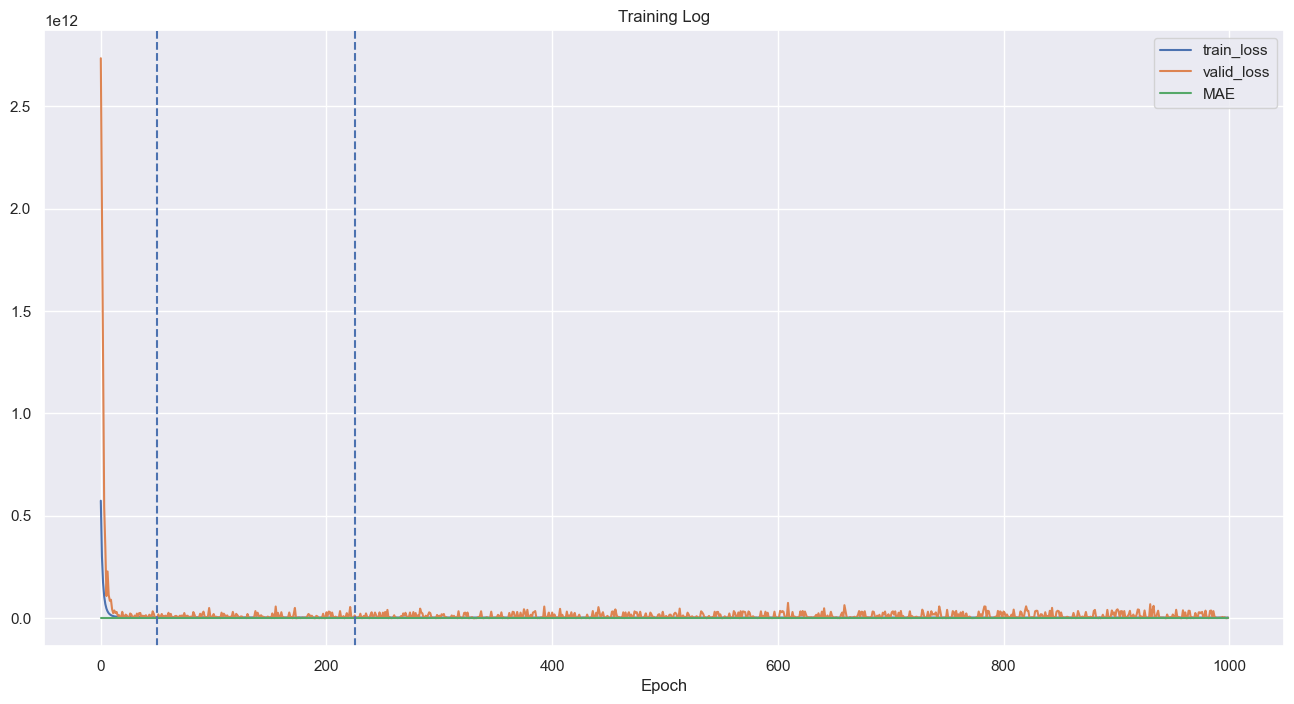

In [12]:
_1 = util.visualize_train(
    os.path.join(SAVE_DIR, util.now.strftime('%Y-%m-%d-%H-%M')), 
    # os.path.join(SAVE_DIR, '2024-05-29-21-47'), 
    # os.path.join(SAVE_DIR, '2024-06-05-21-35'), 
    ['valid_loss', 'MAE'],
    v_lines = [50, 225]
)
# util.load_checkpoint(model, SAVE_DIR, '2024-06-05-21-35', epoch=225)

<Axes: xlabel='Epoch'>

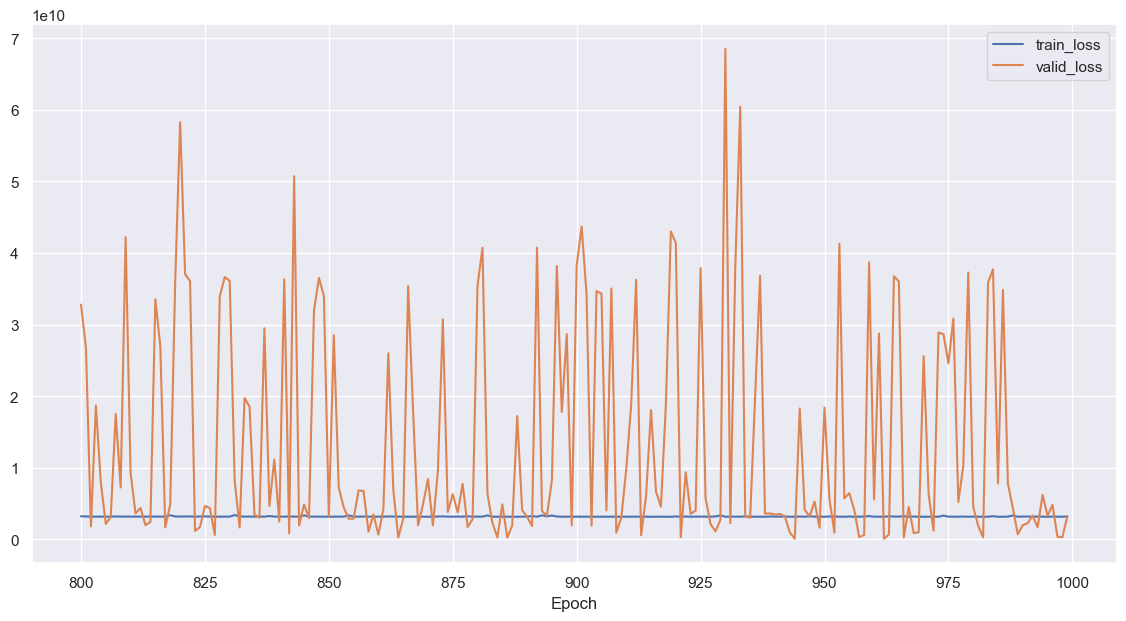

In [13]:
_1[['train_loss', 'valid_loss']][800:].plot(figsize=(14, 7))

start drawing figure, data shape: (400, 3)


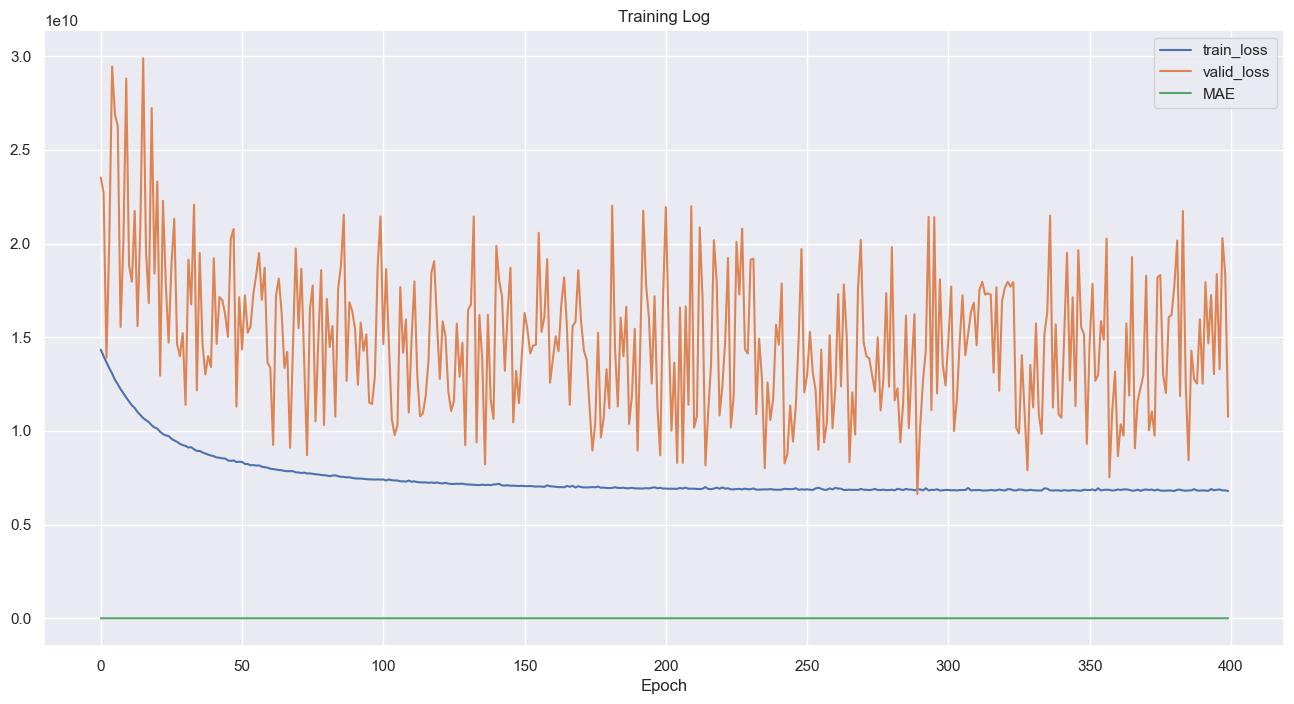

In [17]:
_ = util.visualize_train(
    os.path.join(f'../log/DLinear(norm, win={10}, batch_size={8}, valid_size={20})/', '2024-05-29-21-47'), 
    ['valid_loss', 'MAE'],
    # v_lines = [50, 80]
)

<Axes: xlabel='Epoch'>

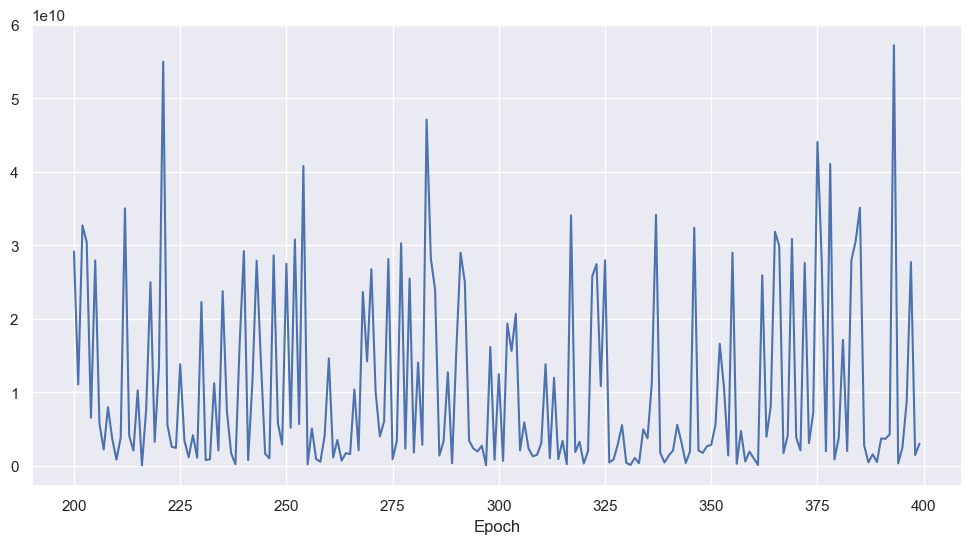

In [20]:
_1['valid_loss'][200:400].plot(figsize=(12, 6))

In [21]:
pred_train_list, y_train_list = [], []
for X, y in train_set:
    time_ticks = X[:, 1:]
    X = X[:, :1]
    y = y[:1]
    
    y_pred = model(X, time_ticks)
    y_train_list.append(y.numpy())
    pred_train_list.append(y_pred.detach().numpy().item())

In [22]:
pred_valid_list, y_valid_list = [], []
for X, y in valid_set:
    time_ticks = X[:, 1:]
    X = X[:, :1]
    y = y[:1]
    
    y_pred = model(X, time_ticks)
    y_valid_list.append(y.numpy())
    pred_valid_list.append(y_pred.detach().numpy().item())

In [23]:
pred_train_list

[285025.4375,
 314410.53125,
 285619.46875,
 270972.84375,
 257266.515625,
 238269.40625,
 235045.09375,
 246322.984375,
 265236.28125,
 200619.90625,
 190208.25,
 190244.21875,
 174163.75,
 265647.75,
 218796.765625,
 193324.75,
 196624.640625,
 167646.84375,
 172880.125,
 199654.953125,
 203144.9375,
 170730.609375,
 139545.40625,
 119363.71875,
 133113.78125,
 120503.0703125,
 121813.09375,
 199064.328125,
 139839.75,
 84007.359375,
 79454.1796875,
 89306.984375,
 267589.71875,
 247074.4375,
 222040.578125,
 201399.3125,
 194396.9375,
 178645.90625,
 189388.84375,
 181868.296875,
 161673.40625,
 216846.03125,
 229396.75,
 209832.3125,
 209278.3125,
 263702.8125,
 211507.84375,
 241283.0625,
 272923.65625,
 244776.28125,
 257937.34375,
 219136.359375,
 217779.09375,
 209566.765625,
 220520.375,
 231824.453125,
 235978.90625,
 221161.296875,
 189400.515625,
 161877.40625,
 183129.96875,
 184232.375,
 229253.875,
 223860.890625,
 206691.796875,
 206792.578125,
 208114.21875,
 195088.26

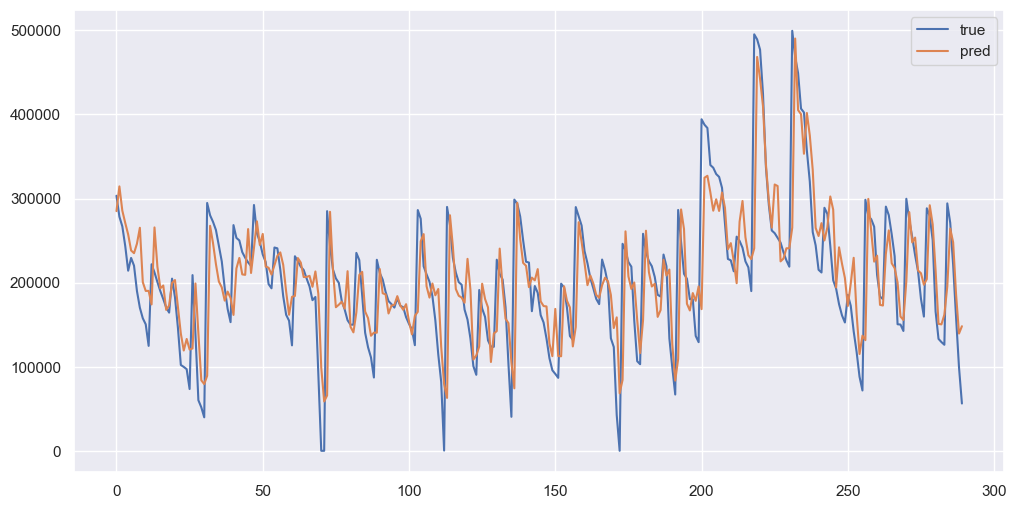

In [24]:
series_id = 0
start = None
end = None
pd.DataFrame(y_train_list)[series_id][start: end].plot(figsize=(12, 6), label='true')
pd.DataFrame(pred_train_list)[series_id][start: end].plot(label='pred')
plt.legend()

<Axes: >

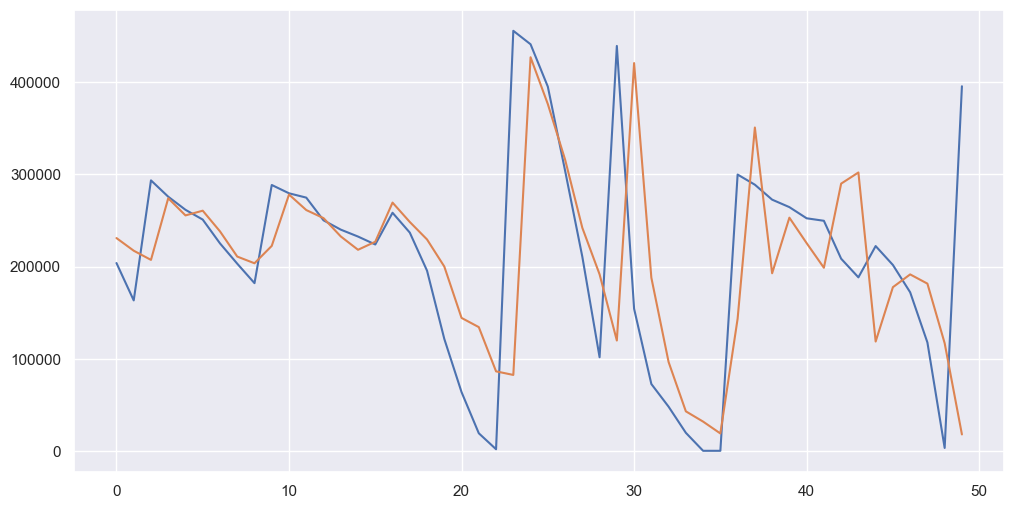

In [25]:
series_id = 0

pd.DataFrame(y_valid_list)[series_id].plot(figsize=(12, 6))
pd.DataFrame(pred_valid_list)[series_id].plot()